# Calculating electron density, K- and F- coronae maps

This notebook shows how to calculate electron density and K/F corona maps from the Metis visible light data by means of the inversion method reported in Hayes et al. 2001 ApJ, 548, 1081.

Importing necessary packages

In [1]:
%matplotlib inline
#%matplotlib notebook

from os.path import basename
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
import sunpy.map

In this notebook we will make use of a number of auxiliary functions collected in `metis_aux_lib.py`

In [2]:
from metis_aux_lib import (
    get_linspace_arr,
    cart_to_polar,
    polar_to_cart,
    set_rsun_phi_axes,
    calc_el_dens_and_K,
    plot_contours,
)

Configuring color maps

In [3]:
Metis_VL_CMAP = cm.get_cmap('RdYlBu_r').copy()
Metis_VL_CMAP.set_bad(color='tab:gray')

Loading pB Metis image and defining the corresponding SunPy map

In [4]:
fname_metis_pb = './data/data_for_nb3_ne_K_F/solo_L2_metis-vl-pb_20211225T001701_V01.fits'
hdu0_pb = fits.open(fname_metis_pb)[0]
hdu0_pb.header['RSUN_OBS'] = hdu0_pb.header['RSUN_ARC']

map_metis_pb = sunpy.map.Map(hdu0_pb.data, hdu0_pb.header)
map_metis_pb_rotated = map_metis_pb.rotate()

Defining an array of heliocentric distances `r_arr` and polar angles `phi_arr` at which the polar map will be calculated

In [5]:
fov1 = hdu0_pb.header['INN_FOV']*3600/hdu0_pb.header['RSUN_ARC']  # rsun
fov1 = np.around(fov1, decimals=2)
fov2 = hdu0_pb.header['OUT_FOV']*3600/hdu0_pb.header['RSUN_ARC']  # rsun
fov2 = np.around(fov2, decimals=2)

fov1 += 0.5 # rsun # to cut background and Venus at inner part of the Metis FOV
fov2 -= 0.2 # rsun # to cut hot pixels at outer part of the Metis FOV

dr = 0.01  # rsun
r_arr = get_linspace_arr(fov1, fov2, dr)

phi1 = 0.0  # deg
phi2 = 359.0  # deg
dphi = 1.0  # deg
phi_arr = get_linspace_arr(phi1, phi2, dphi)

Converting pB map to polar coordinates

In [6]:
xc, yc = map_metis_pb_rotated.world_to_pixel(
    SkyCoord(0*u.arcsec, 0*u.arcsec, frame=map_metis_pb_rotated.coordinate_frame)
) # center of coordinate_frame: Sun center in pixels
xc = xc.value
yc = yc.value
if map_metis_pb_rotated.scale.axis1 != map_metis_pb_rotated.scale.axis2:
    raise ValueError('Error. Scales of the map (CDELT[1/2]) are different.')
rsun_pix = map_metis_pb_rotated.rsun_obs/map_metis_pb_rotated.scale.axis1
rsun_pix = rsun_pix.value

pb_img_arr_polar = cart_to_polar(
    map_metis_pb_rotated.data, r_arr, phi_arr, xc, yc, rsun_pix, cval=np.nan
)

Plotting initial and polar pB images

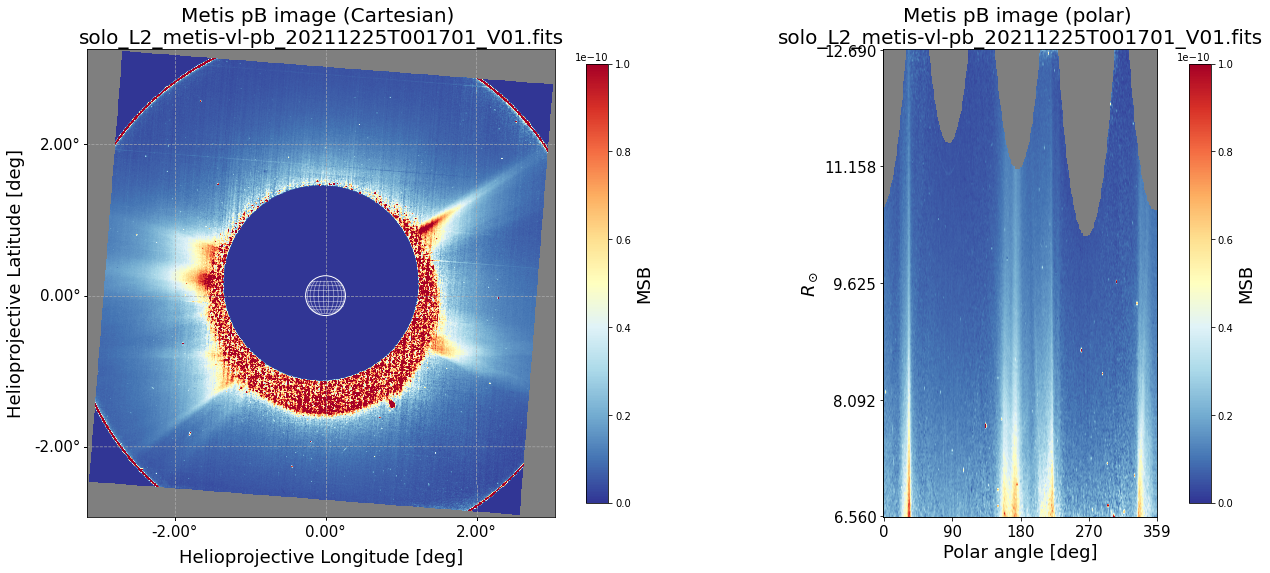

In [7]:
fig = plt.figure(figsize=(18,8))
ax_1 = fig.add_subplot(1, 2, 1, projection=map_metis_pb_rotated)
ax_2 = fig.add_subplot(1, 2, 2)

lon, lat = ax_1.coords
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')
img_pb = ax_1.imshow(map_metis_pb_rotated.data, origin='lower', vmin=0.0, vmax=1e-10, 
                     cmap=Metis_VL_CMAP)
ax_1.grid(ls='--', alpha=0.8)
ax_1.set_title('Metis pB image (Cartesian) \n' + basename(fname_metis_pb), fontsize=20)
ax_1.tick_params(axis='both', which='major', labelsize=15)
ax_1.set_xlabel('Helioprojective Longitude [deg]', fontsize=18)
ax_1.set_ylabel('Helioprojective Latitude [deg]', fontsize=18)
map_metis_pb_rotated.draw_limb(axes=ax_1)
map_metis_pb_rotated.draw_grid(axes=ax_1)
cbar_pb = plt.colorbar(img_pb, ax=ax_1, fraction=0.035)
cbar_pb.set_label('MSB', fontsize=18)



img_pb_polar = ax_2.imshow(pb_img_arr_polar, origin='lower', vmin=0.0, vmax=1e-10, 
                             cmap=Metis_VL_CMAP)
cbar_pb_polar = plt.colorbar(img_pb_polar, ax=ax_2, fraction=0.035)
ax_2.set_title('Metis pB image (polar) \n' + basename(fname_metis_pb), fontsize=20)
cbar_pb_polar.set_label('MSB', fontsize=18)
set_rsun_phi_axes(ax_2, pb_img_arr_polar, r_arr, phi_arr)

fig.tight_layout()

Calculating electron density profiles map and K-corona images by means of the inversion method (Hayes et al. 2001 ApJ, 548, 1081)

In [8]:
el_dens_arr_polar, K_arr_polar = calc_el_dens_and_K(pb_img_arr_polar, r_arr)


calc_binvertdata:
 - x = (6.56-12.690000000000001, dx=0.010)
 - k = [1, 2, 3, 4]
 - q = 0.63 
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................Done


Plotting electron density and K-corona maps together with pB image

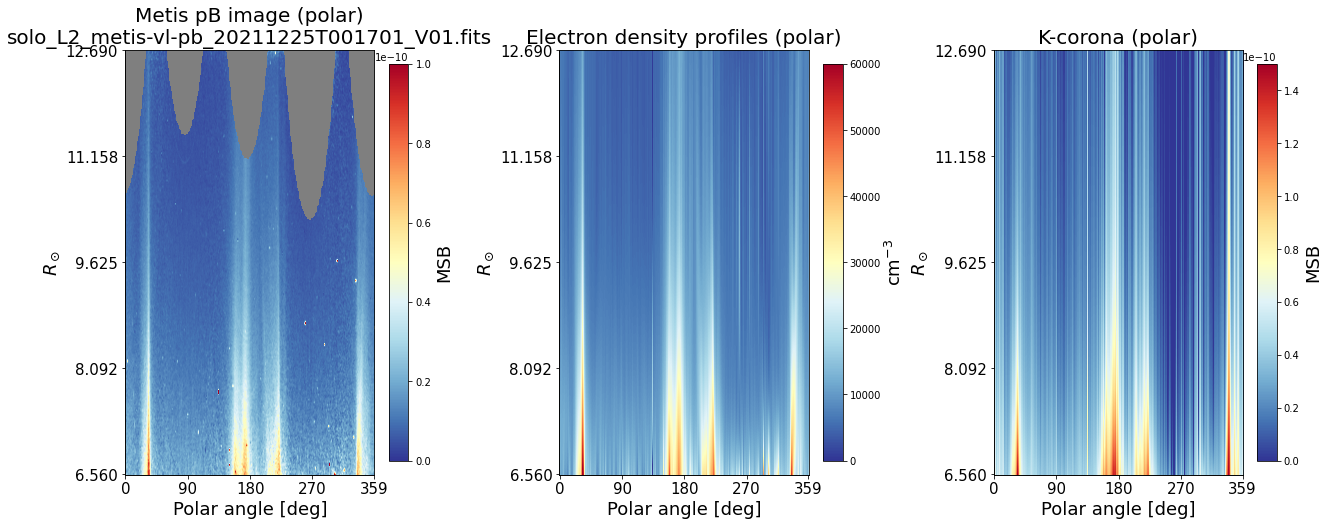

In [9]:
fig2, axs2 = plt.subplots(1, 3, figsize=(18,8))

img_pb_polar = axs2[0].imshow(pb_img_arr_polar, origin='lower', vmin=0.0, vmax=1e-10, 
                              cmap=Metis_VL_CMAP)
cbar_pb = plt.colorbar(img_pb_polar, ax=axs2[0], fraction=0.07)
axs2[0].set_title('Metis pB image (polar)\n' + basename(fname_metis_pb), fontsize=20)
cbar_pb.set_label('MSB', fontsize=18)
set_rsun_phi_axes(axs2[0], pb_img_arr_polar, r_arr, phi_arr)

img_el_dens_polar = axs2[1].imshow(el_dens_arr_polar, origin='lower', vmin=0.0, vmax=6e4, 
                                   cmap=Metis_VL_CMAP)
cbar_ne = plt.colorbar(img_el_dens_polar, ax=axs2[1], fraction=0.07)
axs2[1].set_title('Electron density profiles (polar)', fontsize=20)
cbar_ne.set_label(r'${\rm cm}^{-3}$', fontsize=18)
set_rsun_phi_axes(axs2[1], el_dens_arr_polar, r_arr, phi_arr)

img_K_polar = axs2[2].imshow(K_arr_polar, origin='lower', vmin=0.0, vmax=1.5e-10, 
                             cmap=Metis_VL_CMAP)
cbar_K = plt.colorbar(img_K_polar, ax=axs2[2], fraction=0.07)
axs2[2].set_title('K-corona (polar)', fontsize=20)
cbar_K.set_label('MSB', fontsize=18)
set_rsun_phi_axes(axs2[2], K_arr_polar, r_arr, phi_arr)

fig2.tight_layout()

Loading simultaneous tB Metis image ...

In [10]:
fname_metis_tb = './data/data_for_nb3_ne_K_F/solo_L2_metis-vl-tb_20211225T001701_V01.fits'
hdu0_tb = fits.open(fname_metis_tb)[0]
hdu0_tb.header['RSUN_OBS'] = hdu0_tb.header['RSUN_ARC']

map_metis_tb = sunpy.map.Map(hdu0_tb.data, hdu0_tb.header)
map_metis_tb_rotated = map_metis_tb.rotate()

xc_tb, yc_tb = map_metis_tb_rotated.world_to_pixel(
    SkyCoord(0*u.arcsec, 0*u.arcsec, frame=map_metis_tb_rotated.coordinate_frame)
) # center of coordinate_frame: Sun center in pixels
xc_tb = xc_tb.value
yc_tb = yc_tb.value
if map_metis_tb_rotated.scale.axis1 != map_metis_tb_rotated.scale.axis2:
    raise ValueError('Error. Scale of the map (CDELT[1/2]) are different')
rsun_pix_tb = map_metis_tb_rotated.rsun_obs/map_metis_tb_rotated.scale.axis1
rsun_pix_tb = rsun_pix_tb.value

tb_img_arr_polar = cart_to_polar(
    map_metis_tb_rotated.data, r_arr, phi_arr, xc_tb, yc_tb, rsun_pix_tb, cval=np.nan
)

... and calculating a model of the F-corona 

In [11]:
F_arr_polar = tb_img_arr_polar - K_arr_polar

Comparing tB, K- and F- coronae maps

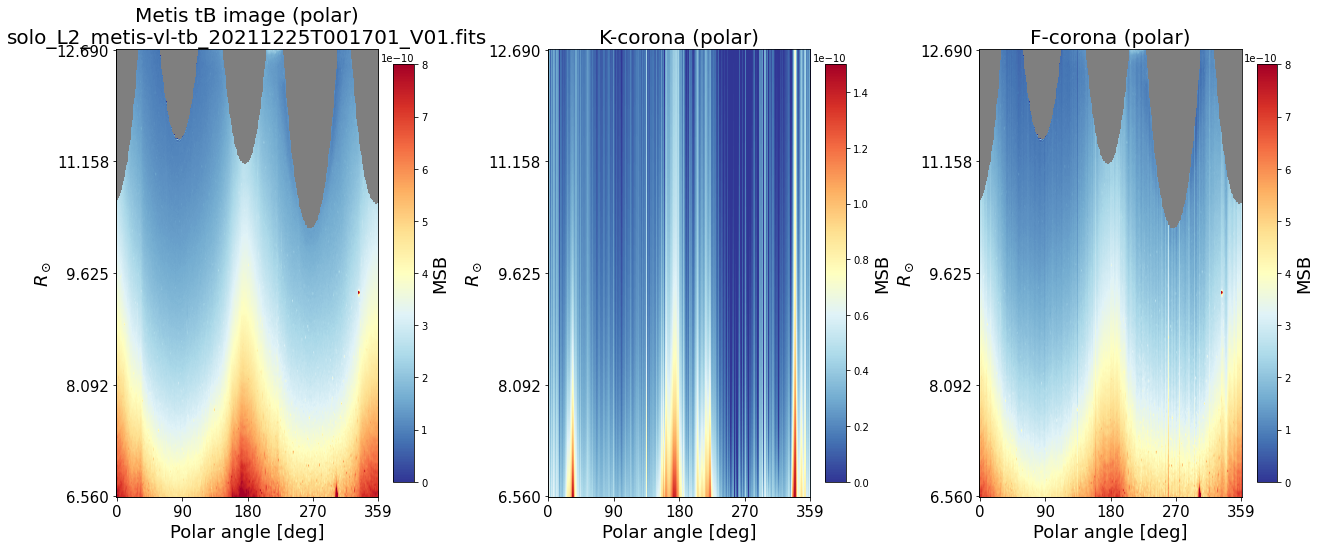

In [12]:
fig3, axs3 = plt.subplots(1, 3, figsize=(18,8))

img_tb_polar = axs3[0].imshow(tb_img_arr_polar, origin='lower', vmin=0.0, vmax=8e-10, 
                              cmap=Metis_VL_CMAP)
cbar_tb = plt.colorbar(img_tb_polar, ax=axs3[0], fraction=0.07)
axs3[0].set_title('Metis tB image (polar)\n' + basename(fname_metis_tb), fontsize=20)
cbar_tb.set_label('MSB', fontsize=18)
set_rsun_phi_axes(axs3[0], tb_img_arr_polar, r_arr, phi_arr)
#plot_contours(axs3[0], tb_img_arr_polar, vmin=img_tb_polar.get_clim()[0], vmax=img_tb_polar.get_clim()[1]) # optional

img_K_polar = axs3[1].imshow(K_arr_polar, origin='lower', vmin=0.0, vmax=1.5e-10, 
                             cmap=Metis_VL_CMAP)
cbar_K = plt.colorbar(img_K_polar, ax=axs3[1], fraction=0.07)
axs3[1].set_title('K-corona (polar)', fontsize=20)
cbar_K.set_label('MSB', fontsize=18)
set_rsun_phi_axes(axs3[1], K_arr_polar, r_arr, phi_arr)

img_F_polar = axs3[2].imshow(F_arr_polar, origin='lower', vmin=0.0, vmax=8e-10, 
                             cmap=Metis_VL_CMAP)
cbar_F = plt.colorbar(img_F_polar, ax=axs3[2], fraction=0.07)
axs3[2].set_title('F-corona (polar)', fontsize=20)
cbar_F.set_label('MSB', fontsize=18)
set_rsun_phi_axes(axs3[2], F_arr_polar, r_arr, phi_arr)
#plot_contours(axs3[2], F_arr_polar, vmin=img_F_polar.get_clim()[0], vmax=img_F_polar.get_clim()[1]) # optional

fig3.tight_layout()

Finally, converting back all polar maps to Cartesian coordinates

In [13]:
cart_img_shape = hdu0_pb.data.shape

pb_img_arr_cart = polar_to_cart(
    pb_img_arr_polar, cart_img_shape, cart_img_shape[0]/2, 
    cart_img_shape[1]/2, rsun_pix, fov1, fov2, dr
)
tb_img_arr_cart = polar_to_cart(
    tb_img_arr_polar, cart_img_shape, cart_img_shape[0]/2, 
    cart_img_shape[1]/2, rsun_pix, fov1, fov2, dr
)
el_dens_arr_cart = polar_to_cart(
    el_dens_arr_polar, cart_img_shape, cart_img_shape[0]/2, 
    cart_img_shape[1]/2, rsun_pix, fov1, fov2, dr
)
K_arr_cart = polar_to_cart(
    K_arr_polar, cart_img_shape, cart_img_shape[0]/2, 
    cart_img_shape[1]/2, rsun_pix, fov1, fov2, dr
)
F_arr_cart = polar_to_cart(
    F_arr_polar, cart_img_shape, cart_img_shape[0]/2, 
    cart_img_shape[1]/2, rsun_pix, fov1, fov2, dr
)

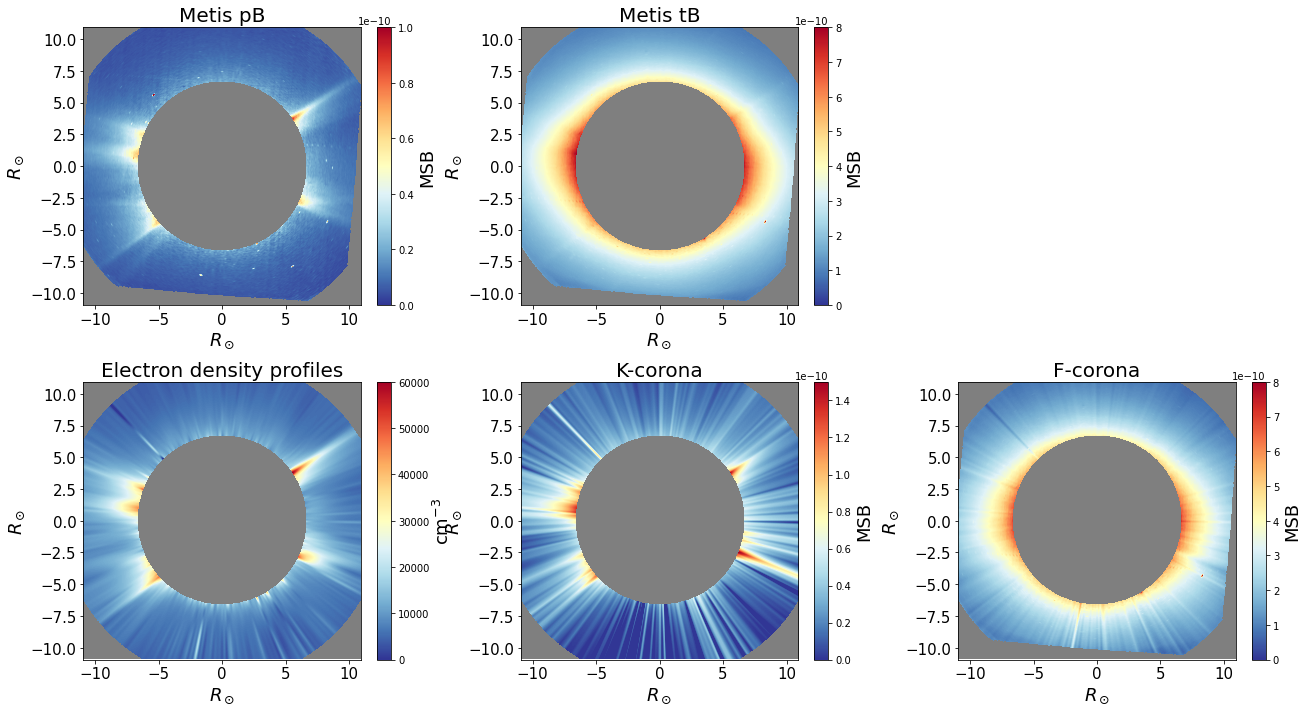

In [14]:
fig4, axs4 = plt.subplots(2, 3, figsize=(18,10))
axs4[0,2].remove()
cbar_fraction = 0.05
img_extent = 1.0/rsun_pix * np.array(
    [-cart_img_shape[0]/2.0, cart_img_shape[0]/2.0, 
     -cart_img_shape[1]/2.0, cart_img_shape[1]/2.0]
)

img_pb_c = axs4[0,0].imshow(pb_img_arr_cart, origin='lower', vmin=0.0, vmax=1e-10, 
                            cmap=Metis_VL_CMAP, extent=img_extent)
cbar_pb_c = plt.colorbar(img_pb_c, ax=axs4[0,0], fraction=cbar_fraction)
axs4[0,0].set_title('Metis pB', fontsize=20)
cbar_pb_c.set_label('MSB', fontsize=18)

img_tb_c = axs4[0,1].imshow(tb_img_arr_cart, origin='lower', vmin=0.0, vmax=8e-10, 
                            cmap=Metis_VL_CMAP, extent=img_extent)
cbar_tb_c = plt.colorbar(img_tb_c, ax=axs4[0,1], fraction=cbar_fraction)
axs4[0,1].set_title('Metis tB', fontsize=20)
cbar_tb_c.set_label('MSB', fontsize=18)

img_ne_c = axs4[1,0].imshow(el_dens_arr_cart, origin='lower', vmin=0.0, vmax=6e4,
                            cmap=Metis_VL_CMAP, extent=img_extent)
cbar_ne_c = plt.colorbar(img_ne_c, ax=axs4[1,0], fraction=cbar_fraction)
axs4[1,0].set_title('Electron density profiles', fontsize=20)
cbar_ne_c.set_label(r'${\rm cm}^{-3}$', fontsize=18)

img_K_c = axs4[1,1].imshow(K_arr_cart, origin='lower', vmin=0.0, vmax=1.5e-10,
                           cmap=Metis_VL_CMAP, extent=img_extent)
cbar_K_c = plt.colorbar(img_K_c, ax=axs4[1,1], fraction=cbar_fraction)
axs4[1,1].set_title('K-corona', fontsize=20)
cbar_K_c.set_label('MSB', fontsize=18)

img_F_c = axs4[1,2].imshow(F_arr_cart, origin='lower', vmin=0.0, vmax=8e-10,
                           cmap=Metis_VL_CMAP, extent=img_extent)
cbar_F_c = plt.colorbar(img_F_c, ax=axs4[1,2], fraction=cbar_fraction)
axs4[1,2].set_title('F-corona', fontsize=20)
cbar_F_c.set_label('MSB', fontsize=18)

for ax in axs4.flatten():
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_xlabel('$R_\odot$', fontsize=18)
    ax.set_ylabel('$R_\odot$', fontsize=18)

fig4.tight_layout()